# OpenStreetMap example

In this example, we download a road network from OSM using the OSMNx package, and then process the result, resulting in a RouteE Compass network dataset.

## requirements

To download an open street maps dataset, we'll need some extra dependnecies which are included with the conda distribution of this pacakge: 

```console
conda create -n routee-compass -c conda-forge python=3.11 nrel.routee.compass 
```

In [1]:
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt

import json

from nrel.routee.compass.io import generate_compass_dataset
from nrel.routee.compass import CompassApp

# Try importing required packages to fail sooner if absent
try:
    import rasterio
    from osgeo import gdal
except:
    raise ImportError("Not all dependencies are installed")

## Building RouteE Compass Dataset

### Get OSM graph

First, we need to get an OSM graph that we can use to convert into the format RouteE Compass expects.

In this example we will load in a road network that covers Golden, Colorado as a small example, but this workflow will work with any osmnx graph (osmnx provides [many graph download operations](https://osmnx.readthedocs.io/en/stable/user-reference.html#module-osmnx.graph)).

In [2]:
g = ox.graph_from_place("Denver, Colorado, USA", network_type="drive")  

### Convert Graph to Compass Dataset

Now, we call the `generate_compass_dataset` function which will convert the osmnx graph into files that are compatible with RouteE Compass.

```{note}
In order to get the most accurate energy results from the routee-powertrain vehicle models, it's important to include road grade information since it plays a large factor in vehicle energy consumption (`add_grade=True`)
That being said, adding grade can be a big lift computationally. In our case, we pull digital elevation model (DEM) raster files from USGS and then use osmnx to append elevation and grade to the graph. If the graph is large, this can take a while to download and could take up a lot of disk space.
So, we recommend that you include grade information in your graph but want to be clear about the requirements for doing so.
```

In [3]:
generate_compass_dataset(g, output_directory="denver_co", add_grade=True)      

processing graph topology and speeds
adding grade information
processing vertices
processing edges
writing vertex files
writing edge files
writing edge attribute files
copying default configuration TOML files
copying RouteE Powertrain models


This will parse the OSM graph and write the RouteE Compass files into a new folder "denver_co/". If you take a look in this directory, you'll notice some `.toml` files like: `osm_default_energy.toml`. 
These are configurations for the compass application. Take a look [here](https://nrel.github.io/routee-compass/config.html) for more information about this file.

## Running

### Load Application

Now we can load the application from one of our config files. 
We'll pick `osm_default_energy.toml` for computing energy optimal routes.

In [4]:
app = CompassApp.from_config_file("denver_co/osm_default_energy.toml")  

uuid file: 100%|██████████| 16994/16994 [00:00<00:00, 7047534.00it/s]/s]

###  Queries

With our application loaded we can start computing routes by passing queries to the app.
To demonstrate, we'll route between two locations in Denver, CO utilzing the grid search input plugin to run three separate searches. 

The `model_name` is the vehicle we want to use for the route. If you look in the folder `denver_co/models` you'll see a collection of routee-powertrain models that can be used to compute the energy for your query.

The `vehicle_state_variable_rates` section defines rates to be applied to each component of the cost function. In this case we use the following costs:

 - 0.655 dollars per mile
 - 20 dollars per hour (or 0.333 dollars per minute)
 - 3 dollars per gallon of gas

The `grid_search` section defines our test cases.
Here, we have three cases: [`least_time`, `least_energy`, `least_cost`].  
In the least_time and least_energy cases, we zero out all other variable contributions using the `state_variable_coefficients` which always get applied to each cost componenet.
In the least_cost case, we allow each cost component to contribute equally and the algorithm will minimize the resulting cost from all components being added together (after getting multiplied by the appropriate `vehicle_state_variable_rate`.

In [5]:
query = [
    {
        "origin_x": -104.969307,
        "origin_y": 39.779021,
        "destination_x": -104.975360,
        "destination_y": 39.693005,
        "model_name": "2016_TOYOTA_Camry_4cyl_2WD",
        "vehicle_rates": {
            "distance": {"type": "factor", "factor": 0.655},
            "time": {"type": "factor", "factor": 0.33},
            "energy_liquid": {"type": "factor", "factor": 3.0},            
        },
        "grid_search": {
            "test_cases": [
              {
                "name": "least_time",
                "weights": {
                  "distance": 0,
                  "time": 1,
                  "energy_liquid": 0
                }
              },
              {
                "name": "least_energy",
                "weights": {
                  "distance": 0,
                  "time": 0,
                  "energy_liquid": 1
                }
              },
              {
                "name": "least_cost",
                "weights": {
                  "distance": 1,
                  "time": 1,
                  "energy_liquid": 1
                }
              }
            ]
          }    
    },
]

Now, let's pass the query to the application.

```{note}
A query can be a single object, or, a list of objects.
If the input is a list of objects, the application will run these queries in parallel over the number of threads defined in the config file under the `paralellism` key (defaults to 2).
```

In [6]:
results = app.run(query)

search: 100%|██████████| 3/3 [00:00<00:00, 64.24it/s].19it/s]

## Analysis

The application returns the results as a list of python dictionaries.
Since we used the grid search to specify three separate searches, we should get three results back:

In [7]:
for r in results:
    error = r.get("error")
    if error is not None:
        print(f"request had error: {error}")

assert len(results)==3, f"expected 3 results, found {len(results)}"

### Traversal and Cost Summaries

Since we have the `traversal` output plugin activated by default, we can take a look at the summary for each result under the `traversal_summary` key.

In [8]:
def pretty_print(dict):
    print(json.dumps(dict, indent=4))
    
shortest_time_result = next(filter(lambda r: r["request"]["name"] == "least_time", results))
least_energy_result = next(filter(lambda r: r["request"]["name"] == "least_energy", results))
least_cost_result = next(filter(lambda r: r["request"]["name"] == "least_cost", results))

Summary of route result for distance, time, and energy:

In [9]:
pretty_print(shortest_time_result["route"]["traversal_summary"])

{
    "distance": 9.152878807061885,
    "energy_liquid": 0.3201305523499191,
    "time": 10.905741862254228
}


And, if we need to know the units and/or the initial conditions for the search, we can look at the state model

In [10]:
pretty_print(shortest_time_result["route"]["state_model"])

{
    "distance": {
        "distance_unit": "miles",
        "initial": 0.0
    },
    "energy_liquid": {
        "energy_unit": "gallons_gasoline",
        "initial": 0.0
    },
    "time": {
        "initial": 0.0,
        "time_unit": "minutes"
    }
}


The cost section shows the costs per unit assigned to the trip, in dollars.

This is based on the user assumptions assigned in the configuration which can be overriden in the route request query.

In [11]:
pretty_print(shortest_time_result["route"]["cost"])

{
    "distance": 5.995135618625535,
    "energy_liquid": 0.9603916570497573,
    "time": 3.5988948145438955,
    "total_cost": 10.554422090219187
}


The cost_model section includes details for how these costs were calculated. 

The user can set different state variable coefficients in the query that are weighted against the vehicle state variable rates.

The algorithm will rely on the weighted costs while the cost summary will show the final costs without weight coefficients applied.

In [12]:
pretty_print(shortest_time_result["route"]["cost_model"])

{
    "cost_aggregation": "sum",
    "distance": {
        "feature": "distance",
        "network_rate": {
            "type": "zero"
        },
        "vehicle_rate": {
            "factor": 0.655,
            "type": "factor"
        },
        "weight": 0.0
    },
    "energy_liquid": {
        "feature": "energy_liquid",
        "network_rate": {
            "type": "zero"
        },
        "vehicle_rate": {
            "factor": 3.0,
            "type": "factor"
        },
        "weight": 0.0
    },
    "time": {
        "feature": "time",
        "network_rate": {
            "type": "zero"
        },
        "vehicle_rate": {
            "factor": 0.33,
            "type": "factor"
        },
        "weight": 1.0
    }
}


Each response object contains this information. The least energy traversal and cost summary are below.

In [13]:
pretty_print(least_energy_result["route"]["traversal_summary"])
pretty_print(least_energy_result["route"]["cost"])

{
    "distance": 6.733433188572938,
    "energy_liquid": 0.26650457849523423,
    "time": 12.777589821994631
}
{
    "distance": 4.4103987385152745,
    "energy_liquid": 0.7995137354857027,
    "time": 4.216604641258229,
    "total_cost": 9.426517115259205
}


What becomes interesting is if we can compare our choices. Here's a quick comparison of the shortest time and least energy routes:

In [14]:
dist_diff = shortest_time_result["route"]["traversal_summary"]["distance"] - least_energy_result["route"]["traversal_summary"]["distance"]
time_diff = shortest_time_result["route"]["traversal_summary"]["time"] - least_energy_result["route"]["traversal_summary"]["time"]
enrg_diff = shortest_time_result["route"]["traversal_summary"]["energy_liquid"] - least_energy_result["route"]["traversal_summary"]["energy_liquid"]
cost_diff = shortest_time_result["route"]["cost"]["total_cost"] - least_energy_result["route"]["cost"]["total_cost"]
dist_unit = shortest_time_result["route"]["state_model"]["distance"]["distance_unit"]
time_unit = shortest_time_result["route"]["state_model"]["time"]["time_unit"]
enrg_unit = shortest_time_result["route"]["state_model"]["energy_liquid"]["energy_unit"]
print(f" - distance: {dist_diff:.2f} {dist_unit} further with time-optimal")
print(f" - time: {-time_diff:.2f} {time_unit} longer with energy-optimal")
print(f" - energy: {enrg_diff:.2f} {enrg_unit} more with time-optimal")
print(f" - cost: ${cost_diff:.2f} more with time-optimal")

 - distance: 2.42 miles further with time-optimal
 - time: 1.87 minutes longer with energy-optimal
 - energy: 0.05 gallons_gasoline more with time-optimal
 - cost: $1.13 more with time-optimal


In addition to the summary, the result also contains much more information.
Here's a list of all the different sections that get returned:

In [15]:
def print_keys(d, indent=0):
    for k in sorted(d.keys()):
        print(f"{' '*indent} - {k}")
        if isinstance(d[k], dict):
            print_keys(d[k], indent+2)
print_keys(least_energy_result)

 - destination_vertex_uuid
 - iterations
 - origin_vertex_uuid
 - output_plugin_executed_time
 - request
   - destination_vertex
   - destination_x
   - destination_y
   - model_name
   - name
   - origin_vertex
   - origin_x
   - origin_y
   - query_weight_estimate
   - vehicle_rates
     - distance
       - factor
       - type
     - energy_liquid
       - factor
       - type
     - time
       - factor
       - type
   - weights
     - distance
     - energy_liquid
     - time
 - route
   - cost
     - distance
     - energy_liquid
     - time
     - total_cost
   - cost_model
     - cost_aggregation
     - distance
       - feature
       - network_rate
         - type
       - vehicle_rate
         - factor
         - type
       - weight
     - energy_liquid
       - feature
       - network_rate
         - type
       - vehicle_rate
         - factor
         - type
       - weight
     - time
       - feature
       - network_rate
         - type
       - vehicle_rate
       

### Plotting

We can also plot the results to see the difference between the two routes.

In [16]:
from nrel.routee.compass.plot import plot_route_folium, plot_routes_folium

We can use the `plot_route_folium` function to plot single routes, passing in the `line_kwargs` parameter to customize the folium linestring:

In [17]:
m = plot_route_folium(shortest_time_result, line_kwargs={"color": "red", "tooltip": "Shortest Time"})
m = plot_route_folium(least_energy_result, line_kwargs={"color": "green", "tooltip": "Least Energy"}, folium_map=m)
m = plot_route_folium(least_cost_result, line_kwargs={"color": "blue", "tooltip": "Least Cost"}, folium_map=m)
m

We can also use the plot_routes_folium function and pass in multiple results. The function will color the routes based on the `value_fn` which takes a single result as an argument. For example, we can tell it to color the routes based on the total energy usage. 

In [18]:
folium_map = plot_routes_folium(results, value_fn=lambda r: r["route"]["traversal_summary"]["energy_liquid"], color_map="plasma")
folium_map

And the `plot_routes_folium` can also accept an existing `folium_map` parameter. Let's query our application with different origin and destination places:

In [21]:
query[0] = {
    **query[0],
    "origin_x": -105.081406,
    "origin_y": 39.667736,
    "destination_x": -104.95414,
    "destination_y": 39.65316,
}
new_results = app.run(query)


search: 100%|██████████| 3/3 [00:00<00:00, 64.05it/s]1.82it/s]

In [22]:
folium_map = plot_routes_folium(new_results, value_fn=lambda r: r["route"]["traversal_summary"]["energy_liquid"], color_map="plasma", folium_map=folium_map)
folium_map


### Tradeoffs

Lastly, let's look at the tradeoffs for taking one route versus another.

First we'll gather some of the summary values into a dataframe:

In [23]:
c = []
for r in results:
    c.append({ 
        "scenario": r["request"]["name"],
        "time_minutes": r["route"]["traversal_summary"]["time"],
        "distance_miles": r["route"]["traversal_summary"]["distance"],
        "energy_gge": r["route"]["traversal_summary"]["energy_liquid"],
        "cost_dollars": r["route"]["cost"]["total_cost"],
    })

In [24]:
df = pd.DataFrame(c)
df

,scenario,time_minutes,distance_miles,energy_gge,cost_dollars
0,least_time,10.905742,9.152879,0.320131,10.554422
1,least_cost,13.158831,6.470756,0.280432,9.422056
2,least_energy,12.777590,6.733433,0.266505,9.426517
3,least_time,20.597169,11.101926,0.449156,15.416296
4,least_cost,20.597169,11.101926,0.449156,15.416296
5,least_energy,20.597169,11.101926,0.449156,15.416296


Now, let's look at the tradeoff between time and cost.

Text(0.5, 1.0, 'Cost vs Time by Scenario')

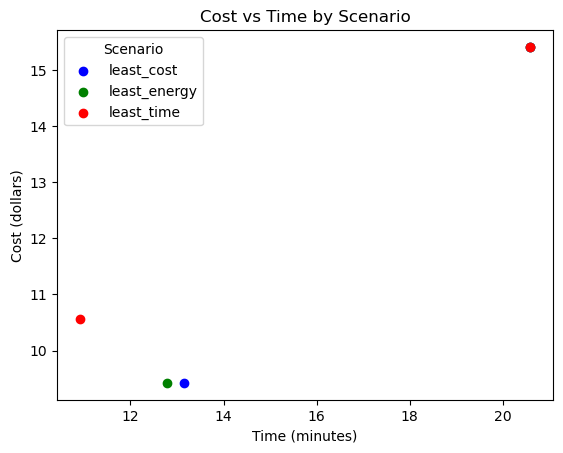

In [25]:
fig, ax = plt.subplots()
colors = {'least_time':'red', 'least_cost':'blue', 'least_energy':'green'}

for scenario, group in df.groupby('scenario'):
    ax.scatter(group['time_minutes'], group['cost_dollars'], color=colors[scenario], label=scenario)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Cost (dollars)')
ax.legend(title='Scenario')
plt.title('Cost vs Time by Scenario')

Next, let's look at the time versus energy tradeoff

Text(0.5, 1.0, 'Cost vs Energy by Scenario')

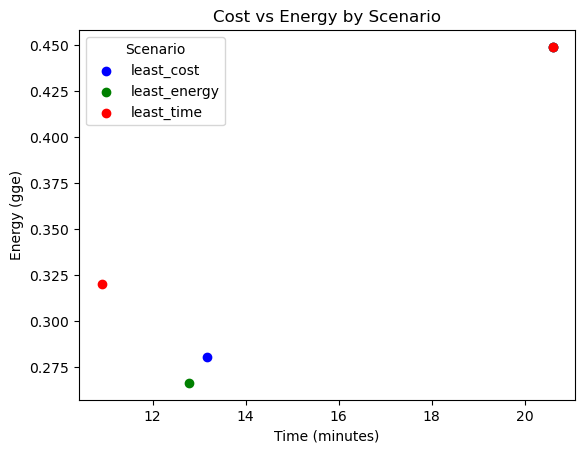

In [26]:
fig, ax = plt.subplots()

for scenario, group in df.groupby('scenario'):
    ax.scatter(group['time_minutes'], group['energy_gge'], color=colors[scenario], label=scenario)

ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Energy (gge)')
ax.legend(title='Scenario')
plt.title('Cost vs Energy by Scenario')

## Other Powertrains

In this section we'll look at some nuance when running different powertrain types.

First we'll look at a battery electric vehicle (BEV). 
To see all the models we can use you can take a look at the folder `denver_co/models` and it will have a large list of RouteE Powertrain models available to us.
Note that you can also train your own RouteE Powertrain models.
Take a look at [this notebook](https://github.com/NREL/routee-powertrain/blob/main/docs/model_training-smartcore.ipynb) for more details.

In this case we'll select a 2017 Chevrolet Bolt and modify the query above to make it compatible with that vehicle.
The only major changes to note is that we need to provide a weight and vehicle rate for `energy_electric` instead of `energy_liquid`.

In [61]:
bev_query = [
    {
        "origin_x": -104.969307,
        "origin_y": 39.779021,
        "destination_x": -104.975360,
        "destination_y": 39.693005,
        "model_name": "2017_CHEVROLET_Bolt",
        "starting_soc_percent": 100,
        "vehicle_rates": {
            "distance": {"type": "factor", "factor": 0.655},
            "time": {"type": "factor", "factor": 0.33},
            "energy_electric": {"type": "factor", "factor": 0.5},            
        },
        "grid_search": {
            "test_cases": [
              {
                "name": "least_time",
                "weights": {
                  "distance": 0,
                  "time": 1,
                  "energy_electric": 0
                }
              },
              {
                "name": "least_energy",
                "weights": {
                  "distance": 0,
                  "time": 0,
                  "energy_electric": 1
                }
              },
              {
                "name": "least_cost",
                "weights": {
                  "distance": 1,
                  "time": 1,
                  "energy_electric": 1
                }
              }
            ]
          }    
    },
]

In [62]:
bev_result = app.run(bev_query)

search: 100%|██████████| 3/3 [00:00<00:00, 60.69it/s]1.87it/s]

Now we can take a look at the results.
First let's take out the first result and look at the state model.

In [63]:
bev_result[0]["route"]["state_model"]

{'battery_state': {'format': {'floating_point': {'initial': 100.0}},
  'type': 'soc',
  'unit': 'percent'},
 'distance': {'distance_unit': 'miles', 'initial': 0.0},
 'energy_electric': {'energy_unit': 'kilowatt_hours', 'initial': 0.0},
 'time': {'initial': 0.0, 'time_unit': 'minutes'}}

Here we see that we're tracking both energy (in kwh) and the battery state (in percent).
If we then look at the traversal summary we see how much energy the vehicle consumed and we also note the state of the battery at the end of the route

In [64]:
bev_result[0]["route"]["traversal_summary"]

{'battery_state': 95.01748532286013,
 'distance': 9.152878807061885,
 'energy_electric': 2.989508806283898,
 'time': 10.905741862254228}

Next we'll look at a Plug In Hybrid Electric Vehicle (PHEV).
In this query, everything will be similar to the battery electric vehicle but we'll be tracking both electrical energy and gasoline energy.
By default, the PHEV will run using battery energy exclusively (starting at 100% SOC) and when the battery runs out, the vehicle will switch to it's hybrid mode, using primarily gasoline energy.

In [65]:
phev_query = [
    {
        "origin_x": -104.969307,
        "origin_y": 39.779021,
        "destination_x": -104.975360,
        "destination_y": 39.693005,
        "model_name": "2016_CHEVROLET_Volt",
        "starting_soc_percent": 100,
        "vehicle_rates": {
            "distance": {"type": "factor", "factor": 0.655},
            "time": {"type": "factor", "factor": 0.33},
            "energy_electric": {"type": "factor", "factor": 0.5},
            "energy_liquid": {"type": "factor", "factor": 3.0},   
        },
        "grid_search": {
            "test_cases": [
              {
                "name": "least_time",
                "weights": {
                  "distance": 0,
                  "time": 1,
                  "energy_electric": 0,
                  "energy_liquid": 0
                }
              },
              {
                "name": "least_energy",
                "weights": {
                  "distance": 0,
                  "time": 0,
                  "energy_electric": 1,
                  "energy_liquid": 1
                }
              },
              {
                "name": "least_cost",
                "weights": {
                  "distance": 1,
                  "time": 1,
                  "energy_electric": 1,
                  "energy_liquid": 1
                }
              }
            ]
          }    
    },
]

In [66]:
phev_results = app.run(phev_query)

search: 100%|██████████| 3/3 [00:00<00:00, 42.61it/s]0.41it/s]

In [67]:
phev_results[0]["route"]["state_model"]

{'battery_state': {'format': {'floating_point': {'initial': 100.0}},
  'type': 'soc',
  'unit': 'percent'},
 'distance': {'distance_unit': 'miles', 'initial': 0.0},
 'energy_electric': {'energy_unit': 'kilowatt_hours', 'initial': 0.0},
 'energy_liquid': {'energy_unit': 'gallons_gasoline', 'initial': 0.0},
 'time': {'initial': 0.0, 'time_unit': 'minutes'}}

In [69]:
phev_results[0]["route"]["traversal_summary"]

{'battery_state': 78.14805794509697,
 'distance': 9.152878807061885,
 'energy_electric': 2.622233046588368,
 'energy_liquid': 0.0,
 'time': 10.905741862254228}

Note that we get back both electrical and gasoline energy values and in this case the route was short enough that the vehicle was able run on the battery exclusively.

At this point we could repeat all of the analysis above with the new results (plotting, tradeoffs, etc).